# 2D Electromagnetic FDTD in Python

The <a href="https://en.wikipedia.org/wiki/Finite-difference_time-domain_method" target="_blank">finite difference time domain (FDTD)</a> algorithm is a numerical method used to solve partial differential equations which have both spatial and temporal derivatives such as <a href="https://en.wikipedia.org/wiki/Maxwell's_equations" target="_blank">Maxwell's equations</a> or <a href="https://en.wikipedia.org/wiki/Seismic_wave" target="_blank">seismic waves</a> propagating through the earth. Such equations are impossible to solve analytically for complex systems such as <a href="https://en.wikipedia.org/wiki/Random_laser" target="_blank">random lasers</a> or <a href="https://en.wikipedia.org/wiki/Volcano_tectonic_earthquake" target="_blank">volcanic systems</a>, and scientists have to make use of numerical methods to better understand how such systems behave under various conditions. In this post, we will explore how to implement a two dimensional electromagnetic FDTD algorithm in Python.

## Maxwell's Equations

We start from Maxwell's equations in <a href="https://en.wikipedia.org/wiki/Gaussian_units" target="_blank">Gaussian units</a>, and scale the units such that the value of the speed of light _c_ = 1, and assume that no current _J_ is present in the system:

∇ · __E__ = 4πρ,

∇ · __B__ = 0,

∇ × __E__ = -__Ḃ__,

∇ × __B__  = __Ė__,

where __Ḃ__ and __Ė__ are the time derivatives of the magnetic field and electric field respectively.

## From Maxwell's Equations to FDTD

Unlike the <a href="https://github.com/natsunoyuki/blog_posts/blob/main/physics/1D%20Electromagnetic%20FDTD%20in%20Python.ipynb" target="_blank">1 dimensional system</a> where we only needed to concern ourselves with derivatives only in 1 direction, the 2 dimensional system requires us to make certain careful alignment of the axes in order to make the FDTD equations straightforward. 

Recall that electromagnetic waves are transverse waves, where the electric and magnetic fields oscillate in a plane perpendicular to the propagation direction. In a 2 dimensional system, this means that the propagation direction will occur along the x-y plane. This means that we can align either the magnetic field along the z-axis (resulting in an electric field component in the x-y plane), or the electric field along the z-axis (resulting in a magnetic field compoenent in the x-y plane) in order to simplify the calculations involved. The former is more commonly referred to as TEz (transverse electric) polarization, while the latter as TMz (transverse magnetic) polarization.

In this post we will explore the TMz case which is arguably easier to implement and than the TEz case, especially for more complex systems such as lasers.

## TMz Polarization

In the TMz polarization case where the electric field is aligned to the z-axis, only <i>E</i><sub><i>z</i></sub>, <i>H</i><sub><i>x</i></sub> and <i>H</i><sub><i>y</i></sub> are non-zero, where __B__ = <i>μ</i>__H__.  We set <i>μ</i> = 1 in order to simplify the calculations.

Also, in order to implement the FDTD algorithm we only need to use the third and fourth Maxwell's equations. The third equation ∇ × __E__ = -__Ḣ__ can be written out more clearly as:

(∇ × __E__)<sub><i>i</i></sub> = ε<sub><i>ijk</i></sub>∇<sub><i>j</i></sub>_E_<sub><i>k</i></sub> = -<i>Ḣ</i><sub><i>i</i></sub>,

<i>i</i>, <i>j</i>, <i>k</i> ∈ {_x_, _y_, _z_},

where ε<sub><i>ijk</i></sub> is the Levi-Civita symbol, ∇<sub><i>j</i></sub> is the <i>j</i>th spatial derivative, and _E_<sub><i>k</i></sub> is the <i>k</i>th spatial component of the electric field. 


For the 2 dimensional TMz case, this equation reduces to the 2 equations:

∇<sub><i>y</i></sub><i>E</i><sub><i>z</i></sub> = - <i>Ḣ<sub>x</sub></i>,

∇<sub><i>x</i></sub><i>E</i><sub><i>z</i></sub> = <i>Ḣ<sub>y</sub></i>.

Correspondingly, the fourth equation ∇ × __H__  = __Ė__ can be written out more clearly as:

(∇ × __H__)<sub><i>i</i></sub> = ε<sub><i>ijk</i></sub>∇<sub><i>j</i></sub>_H_<sub><i>k</i></sub> = _Ė_<sub><i>i</i></sub>,

<i>i</i>, <i>j</i>, <i>k</i> ∈ {_x_, _y_, _z_},

where _H_<sub>k</sub> is the <i>k</i>th spatial component of the magnetic field. For the TMz case, this reduces to 1 equation:

∇<sub><i>x</i></sub><i>H</i><sub><i>y</i></sub> - ∇<sub><i>y</i></sub><i>H</i><sub><i>x</i></sub> = _Ė_<sub><i>z</i></sub>.

Therefore, the TMz case requires us to explicitly solve the following 3 equations in both time and space:

∇<sub><i>y</i></sub><i>E</i><sub><i>z</i></sub> = - <i>Ḣ<sub>x</sub></i>,

∇<sub><i>x</i></sub><i>E</i><sub><i>z</i></sub> = <i>Ḣ<sub>y</sub></i>,

∇<sub><i>x</i></sub><i>H</i><sub><i>y</i></sub> - ∇<sub><i>y</i></sub><i>H</i><sub><i>x</i></sub> = _Ė_<sub><i>z</i></sub>.

## The TMz 2D FDTD Grid

As in the 1 dimensional case, we use a staggered 2 dimensional grid depicted in the figure below simulate the 3 equations above.

<img src="https://github.com/natsunoyuki/blog_posts/blob/main/images/fdtd_2d_grid.jpg?raw=True" alt="drawing" width="500"/>

In each grid unit cell, we place <i>E</i><sub><i>z</i></sub> at the unit cell origin, <i>H</i><sub><i>x</i></sub> halfway along the y-axis and <i>H</i><sub><i>y</i></sub> halfway along the x-axis. In other words, if <i>E</i><sub><i>z</i></sub> has grid indices `[n, m]`, then <i>H</i><sub><i>x</i></sub> will have indices `[n, m+1/2]` and <i>H</i><sub><i>y</i></sub> indices `[n+1/2, m]`.

Additionally, <i>E</i><sub><i>z</i></sub> will be evaluated at integer time steps `t`, while both <i>H</i><sub><i>x</i></sub> and <i>H</i><sub><i>y</i></sub> will be evaluated at half-integer time steps `t+1/2`. This means that the 2 dimensional FDTD grid is staggered in both space and time. This is required as both the electric and magnetic fields interact with each other, and we cannot place all 3 field components at the same spot in both time and space.

Using this grid, during each time step we update both the magnetic and electric fields using the discretized TMz equations using vectorized `numpy` arrays.

<i>Ḣ<sub>x</sub></i> = - ∇<sub><i>y</i></sub><i>E</i><sub><i>z</i></sub>:

`H_x = H_x - dt / dy * (E_z[:, 1:] - E_z[:, :-1])`,

<i>Ḣ<sub>y</sub></i> = ∇<sub><i>x</i></sub><i>E</i><sub><i>z</i></sub>:

`H_y = H_y + dt / dx * (E_z[1:, :] - E_z[:-1, :])`,

_Ė_<sub><i>z</i></sub> = ∇<sub><i>x</i></sub><i>H</i><sub><i>y</i></sub> - ∇<sub><i>y</i></sub><i>H</i><sub><i>x</i></sub>:

`diff_H_x = dt / dy * (H_x[1:-1, 1:] - H_x[1:-1, :-1])`,

`diff_H_y = dt / dx * (H_y[1:, 1:-1] - H_y[:-1, 1:-1])`,

`E_z[1:-1, 1:-1] = E_z[1:-1, 1:-1] + (diff_H_y - diff_H_x)`.

Additionally, during the start of the simulation we introduce a pulse at the centre of the grid to kickstart the electromagnetic wave propagation by adding the pulse directly to the electric field at the specified location:

`E_z[source_x, source_y] = E_z[source_x, source_y] + pulse`.

## Absorbing Boundary Conditions

Absorbing boundary conditions are required to absorb the outwards propagating electric and magnetic fields at the simulation boundary. If absorbing boundary conditions are not implemented, the simulation boundary will act as a perfect electric conductor and fully reflect any outwards propagating waves back into the grid. In this simulation we implement the second order absorbing boundary conditions outlined in chapter 6.6 of <a href="https://eecs.wsu.edu/~schneidj/ufdtd/index.php" target="_blank">Understanding the Finite-Difference Time-Domain Method</a>, John B. Schneider, 2010.

## Coding the 2D FDTD in Python

We code the simulator as a `fdtd2d_tmz` class, with various functions for executing the simulation, plotting the results and creating animations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# FDTD 2D, TMZ polarization simulation.
# The electric field oscillates only in the z direction, while the magnetic field
# oscillates only in the x and y directions. A staggered grid in space is used to 
# simulate E_z, H_x and H_y:
#     H_x(m, n+1/2) 
#     E_z(m, n)     H_y(m+1/2, n)

class fdtd2d_tmz:
    def __init__(self, Nx = 101, Ny = 101, c = 1, dx = 1, dy = 1):
        self.Nx = Nx
        self.Ny = Ny
        self.c = c
        self.dx = dx
        self.dy = dy
        self.dt = min(dx, dy) / np.sqrt(2) / c

        self.x = np.arange(Nx)
        self.y = np.arange(Ny)
        self.X, self.Y = np.meshgrid(self.x, self.y)

        self.source_x = int(Nx / 2)
        self.source_y = int(Ny / 2)

        self.E_z = np.zeros([Nx, Ny])
        self.H_x = np.zeros([Nx, Ny - 1])
        self.H_y = np.zeros([Nx - 1, Ny])

        self.E_z_t = []
        self.H_x_t = []
        self.H_y_t = []

        # Fields at time n, n-1 for Mur ABC
        self.E_z_n = self.E_z.copy()
        self.E_z_n_1 = self.E_z_n.copy()
        self.H_x_n = self.H_x.copy()
        self.H_x_n_1 = self.H_x_n.copy()
        self.H_y_n = self.H_x.copy()
        self.H_y_n_1 = self.H_y_n.copy()
        
    def run(self, n_iter = 150):
        # Mur ABC coefficients
        dtdx = np.sqrt(self.dt / self.dx * self.dt / self.dy)
        dtdx_2 = 1 / dtdx + 2 + dtdx
        c_0 = -(1 / dtdx - 2 + dtdx) / dtdx_2
        c_1 = -2 * (dtdx - 1 / dtdx) / dtdx_2
        c_2 = 4 * (dtdx + 1 / dtdx) / dtdx_2
        
        # FDTD Loop
        for n in range(n_iter):
            # Update magnetic fields at time step n+1/2
            self.H_x = self.H_x - self.dt / self.dy * (self.E_z[:, 1:] - self.E_z[:, :-1])
            self.H_y = self.H_y + self.dt / self.dx * (self.E_z[1:, :] - self.E_z[:-1, :])

            # Update electric field at time step n+1
            diff_H_x = self.dt / self.dy * (self.H_x[1:-1, 1:] - self.H_x[1:-1, :-1])
            diff_H_y = self.dt / self.dx * (self.H_y[1:, 1:-1] - self.H_y[:-1, 1:-1])
            self.E_z[1:-1, 1:-1] = self.E_z[1:-1, 1:-1] + (diff_H_y - diff_H_x)

            # Pulse at time step n+1
            tp = 30
            if n * self.dt <= tp:
                C = (7 / 3) ** 3 * (7 / 4) ** 4
                pulse = C * (n * self.dt / tp) ** 3 * (1 - n * self.dt / tp) ** 4
            else:
                pulse = 0
                
            self.E_z[self.source_x, self.source_y] = self.E_z[self.source_x, self.source_y] + pulse

            # Mur ABC for top boundary
            self.E_z[0, :] = c_0 * (self.E_z[2, :] + self.E_z_n_1[0, :]) +    \
                             c_1 * (self.E_z_n[0, :] + self.E_z_n[2, :] -    \
                                    self.E_z[1, :] - self.E_z_n_1[1, :]) +    \
                             c_2 * self.E_z_n[1, :] - self.E_z_n_1[2, :]

            # Mur ABC for bottom boundary
            self.E_z[-1, :] = c_0 * (self.E_z[-3, :] + self.E_z_n_1[-1, :]) +    \
                              c_1 * (self.E_z_n[-1, :] + self.E_z_n[-3, :] -    \
                                     self.E_z[-2, :] - self.E_z_n_1[-2, :]) +    \
                              c_2 * self.E_z_n[-2, :] - self.E_z_n_1[-3, :]

            # Mur ABC for left boundary
            self.E_z[:, 0] = c_0 * (self.E_z[:, 2] + self.E_z_n_1[:, 0]) +    \
                             c_1 * (self.E_z_n[:, 0] + self.E_z_n[:, 2] -    \
                                    self.E_z[:, 1] - self.E_z_n_1[:, 1]) +    \
                             c_2 * self.E_z_n[:, 1] - self.E_z_n_1[:, 2]

            # Mur ABC for right boundary
            self.E_z[:, -1] = c_0 * (self.E_z[:, -3] + self.E_z_n_1[:, -1]) +    \
                              c_1 * (self.E_z_n[:, -1] + self.E_z_n[:, -3] -    \
                                     self.E_z[:, -2] - self.E_z_n_1[:, -2]) +    \
                              c_2 * self.E_z_n[:, -2] - self.E_z_n_1[:, -3]

            # Store magnetic and electric fields for ABC at time step n
            self.H_x_n_1 = self.H_x_n.copy() # data for t = n-1
            self.H_x_n = self.H_x.copy()     # data for t = n

            self.H_y_n_1 = self.H_y_n.copy() # data for t = n-1
            self.H_y_n = self.H_y.copy()     # data for t = n

            self.E_z_n_1 = self.E_z_n.copy() # data for t = n-1
            self.E_z_n = self.E_z.copy()     # data for t = n

            #self.E_t.append(self.E_z[self.source_x, self.source_y])
            self.E_z_t.append(self.E_z.copy())
            self.H_x_t.append(self.H_x.copy())
            self.H_y_t.append(self.H_y.copy())
            if len(self.E_z_t) > 500:
                del self.E_z_t[0]
                del self.H_x_t[0]
                del self.H_y_t[0]
                            
    def plot_E(self, i = 70):
        if i >= len(self.E_z_t):
            i = len(self.E_z_t) - 1
        plt.figure(figsize = (5, 5))
        plt.pcolormesh(self.x, self.y, self.E_z_t[i].T, 
                       #vmin = np.min(self.E_t), vmax = np.max(self.E_t), 
                       shading = "auto", cmap = "bwr")
        plt.axis("equal")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.grid(True)
        plt.show()
        
    def plot_H(self, i = 70):
        if i >= len(self.H_x_t):
            i = len(self.H_x_t) - 1
        plt.figure(figsize = (10, 5))
        plt.subplot(1, 2, 1)
        plt.pcolormesh(self.X[1:, :], self.Y[1:, :], self.H_x_t[i].T, 
                       #vmin = np.min(self.E_t), vmax = np.max(self.E_t), 
                       shading = "auto", cmap = "bwr")
        plt.axis("equal")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.grid(True)
        plt.subplot(1, 2, 2)
        plt.pcolormesh(self.X[:, 1:], self.Y[:, 1:], self.H_y_t[i].T, 
                       #vmin = np.min(self.E_t), vmax = np.max(self.E_t), 
                       shading = "auto", cmap = "bwr")
        plt.axis("equal")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.grid(True)
        plt.show()
        
    def animate_E(self, file_dir = "fdtd_2d_E_animation.gif", N = 500):
        # animate self.E_z_t as a .gif file.
        # N: number of total steps to save as .gif animation.
        E_z_t = self.E_z_t[-N:]

        fig, ax = plt.subplots(figsize = (5, 5))
        cax = ax.pcolormesh(self.x, self.y, E_z_t[0].T, 
                            vmin = np.min(E_z_t), vmax = np.max(E_z_t), 
                            shading = "auto", cmap = "bwr")
        plt.axis("equal")
        plt.grid(True)

        def animate(i):
            cax.set_array(E_z_t[i].T.flatten())

        anim = FuncAnimation(fig, animate, interval = 50, frames = len(E_z_t) - 1)
        anim.save(file_dir, writer = "pillow")
        plt.show()
        
    def animate_H(self, file_dir = "fdtd_2d_H_animation.gif", N = 500):
        # animate self.H_x,y_t as a .gif file.
        # N: number of total steps to save as .gif animation.
        H_x_t = self.H_x_t[-N:]
        H_y_t = self.H_y_t[-N:]
        
        fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
        cax1 = ax1.pcolormesh(self.X[1:, :], self.Y[1:, :], H_x_t[0].T, 
                              vmin = np.min(H_x_t), vmax = 0.1 * np.max(H_x_t), 
                              shading = "auto", cmap = "gray")
        ax1.axis("equal")
        ax1.grid(True)
        
        cax2 = ax2.pcolormesh(self.X[:, 1:], self.Y[:, 1:], H_y_t[0].T, 
                              vmin = np.min(H_y_t), vmax = 0.1 * np.max(H_y_t), 
                              shading = "auto", cmap = "gray")
        ax2.axis("equal")
        ax2.grid(True)

        def animate(i):
            cax1.set_array(H_x_t[i].T.flatten())
            cax2.set_array(H_y_t[i].T.flatten())

        anim = FuncAnimation(fig, animate, interval = 50, frames = len(H_x_t) - 1)
        anim.save(file_dir, writer = "pillow")
        plt.show()

## Running the Simulation

A simple simulation using the default setup can be run as shown below.

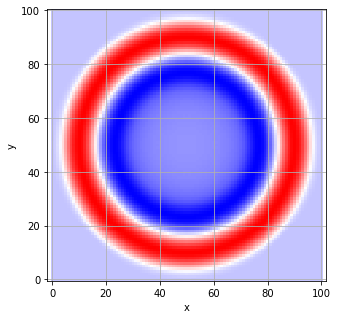

In [2]:
fdtd = fdtd2d_tmz()
fdtd.run(180)
fdtd.plot_E()

## FDTD Animation

A function to animate the simulation built into `fdtd2d_tmz` and can be called using: `fdtd.animate()`. The animation is saved directly into a .gif file as shown in the animation below. A pulse is generated at the centre of the grid, which then propagates outwards through the absorbing boundary conditions situated at the four sides of the square grid.

<img src="https://github.com/natsunoyuki/blog_posts/blob/main/images/fdtd_2d_E_animation.gif?raw=True" alt="drawing" width="300"/>

## More Advanced FDTD Simulations

More FDTD codes can be found on my <a href="https://github.com/natsunoyuki/FDTD" target="_blank">Github repository</a> where I am working on both 1D and 2D laser simulations.

## References
* <a href="https://www.researchgate.net/publication/202924434_Computational_electrodynamics_the_finite-difference_time-domain_method_2nd_ed" target="_blank">Computational electrodynamics: the finite-difference time-domain method. 2nd ed</a>, Allen Taflove and S. C. Hagness, 2000.
* <a href="https://eecs.wsu.edu/~schneidj/ufdtd/index.php" target="_blank">Understanding the Finite-Difference Time-Domain Method</a>, John B. Schneider, 2010.